##### Data exploration on Image dataset
This notebook will explore several data exploration techniques applied to the image dataset in use. These include:
* Total size of the dataset
* Aspect ratio of images
* Image sizes
* Ratio of grayscale to RGB images
* Detection of blurred images

In [289]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
from PIL import Image
import random

In [290]:
# import configs
with open('configs.yaml', 'r') as file:
    configs = yaml.safe_load(file)
DATASET_PATH = configs['dataset_path']
NUM_IMAGES = 5

In [291]:
def plot_random_images(images,num_images_to_display=NUM_IMAGES):
    random_images = random.sample(images, num_images_to_display)

    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(random_images):
        plt.subplot(1, num_images_to_display, i+1)
        image_path = os.path.join(DATASET_PATH, img_path)
    
        with Image.open(image_path) as img:
            if img.mode == 'L':
                plt.imshow(img, cmap='gray')
            if img.mode == 'RGB':
                plt.imshow(img)

        plt.title(img_path)
        plt.axis('off')

In [300]:
# Load dataset

image_data = []
if os.path.exists(DATASET_PATH): 
    try:
        for file in os.listdir(DATASET_PATH):
            image_path = os.path.join(DATASET_PATH, file)
            # Open image and extract properties
            with Image.open(image_path) as img:
                width, height = img.size
                # Append image properties to image_data 
                image_data.append([file, round((os.path.getsize(image_path)/1e6),2), width, height, img.mode,width/height])
        # create pd.DataFrame for further evaluation
        image_df = pd.DataFrame(data=image_data,columns=['File_Name','File_Size(MB)','Width','Height','Mode','Aspect_Ratio'])
        print(image_df)
    except FileNotFoundError:
        print("Error: Dataset path does not exist.")
else:
    print("Error: Dataset path does not exist.")

        File_Name  File_Size(MB)  Width  Height Mode  Aspect_Ratio
0      164911.jpg           0.08    900    1181  RGB      0.762066
1       16500.jpg           0.10    612     783  RGB      0.781609
2       60960.jpg           0.06    600     344  RGB      1.744186
3       10320.jpg           0.05    435     580  RGB      0.750000
4      145941.jpg           0.02    317     474  RGB      0.668776
...           ...            ...    ...     ...  ...           ...
11101  151541.jpg           0.02    280     356  RGB      0.786517
11102   33480.jpg           0.08    467     649  RGB      0.719569
11103   78210.jpg           0.47   1356    2952    L      0.459350
11104  128250.jpg           0.02    300     300  RGB      1.000000
11105  166531.jpg           0.17    600     811  RGB      0.739827

[11106 rows x 6 columns]


In [301]:
# Total dataset size
print(f'Total number of Images: {len(image_df)}')

Total number of Images: 11106


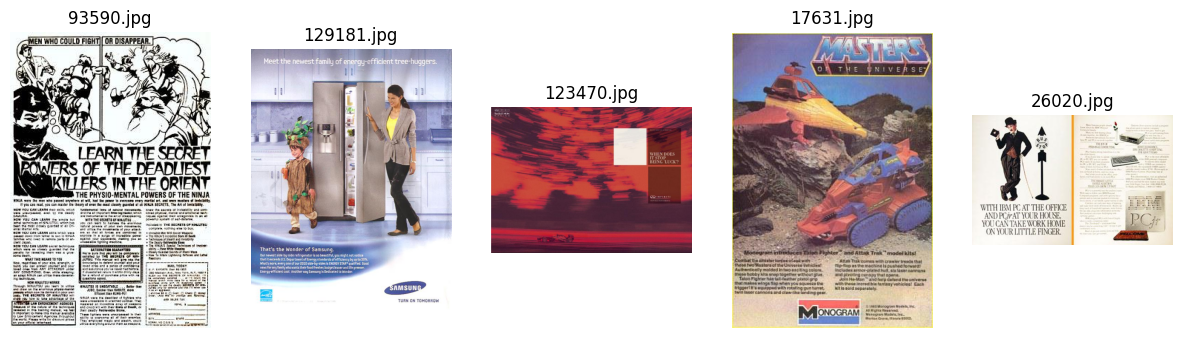

In [306]:
# Sample images from dataset
plot_random_images(list(image_df['File_Name']))

In [307]:
#  Basic Statistical details
image_df.describe()

,File_Size(MB),Width,Height,Aspect_Ratio
count,11106.000000,11106.000000,11106.000000,11106.000000
mean,0.100658,743.113632,735.070322,1.122945
std,0.180273,513.579267,533.361875,0.474673
min,0.010000,256.000000,256.000000,0.202000
25%,0.030000,480.000000,415.000000,0.739793
50%,0.050000,600.000000,600.000000,0.983065
75%,0.100000,800.000000,849.000000,1.474926
max,3.800000,8000.000000,7780.000000,4.250000


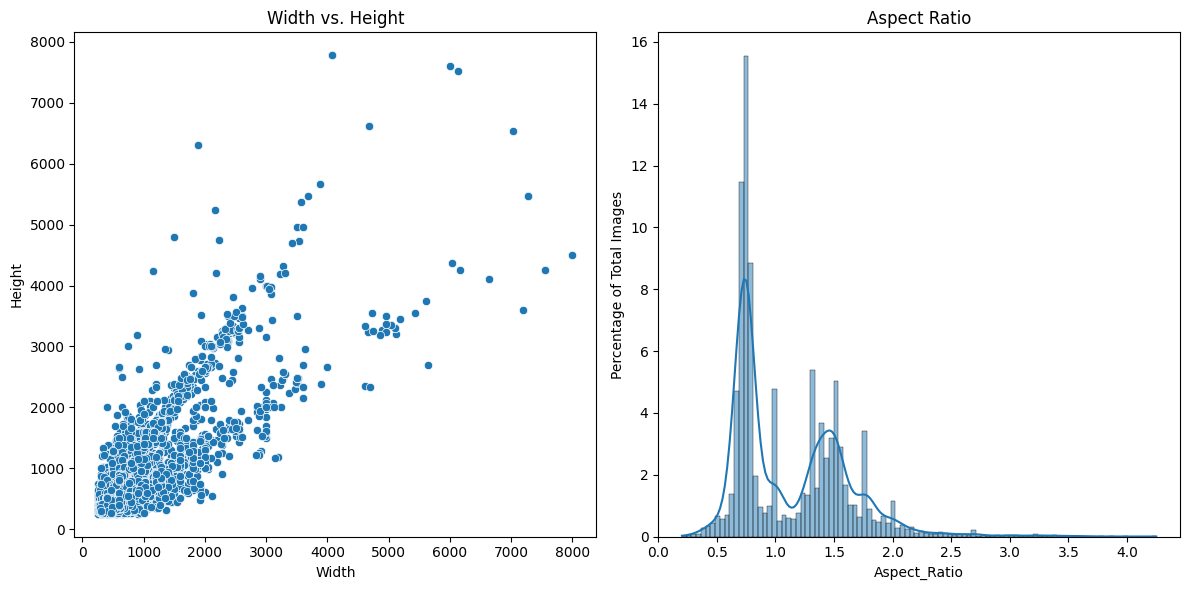

In [308]:
# Dimensions of the image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=image_df,x='Width',y='Height',ax=ax[0])
ax[0].set_title('Width vs. Height')
sns.histplot(data=image_df,x='Aspect_Ratio',bins=100,stat='percent',kde=True, ax=ax[1])
ax[1].set_title('Aspect Ratio')
ax[1].set_ylabel('Percentage of Total Images')

plt.tight_layout()

Text(0, 0.5, 'Percentage of Total Images')

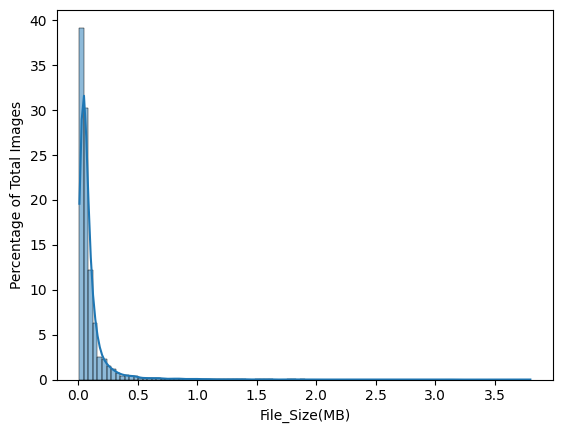

In [309]:
# Image file size
sns.histplot(data=image_df,x='File_Size(MB)',bins=100,stat='percent',kde=True)
plt.ylabel('Percentage of Total Images')

Mode
RGB    11039
L         67
Name: count, dtype: int64


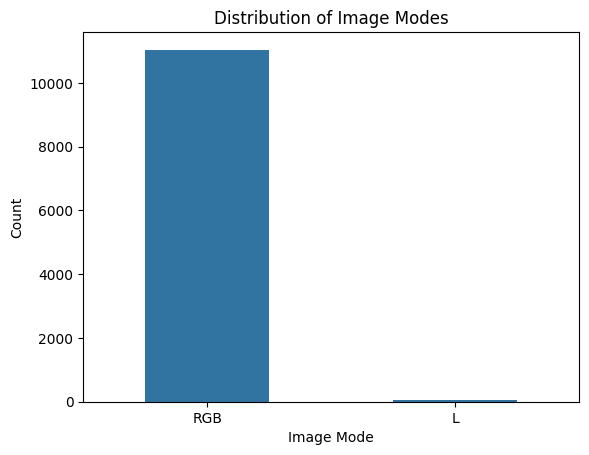

In [310]:
# Image Mode ( RGB or Gray (L))
mode_counts = image_df['Mode'].value_counts()
sns.barplot(x=mode_counts.index, y=mode_counts.values,width=0.5)
plt.title('Distribution of Image Modes')
plt.xlabel('Image Mode')
plt.ylabel('Count')
print(mode_counts)


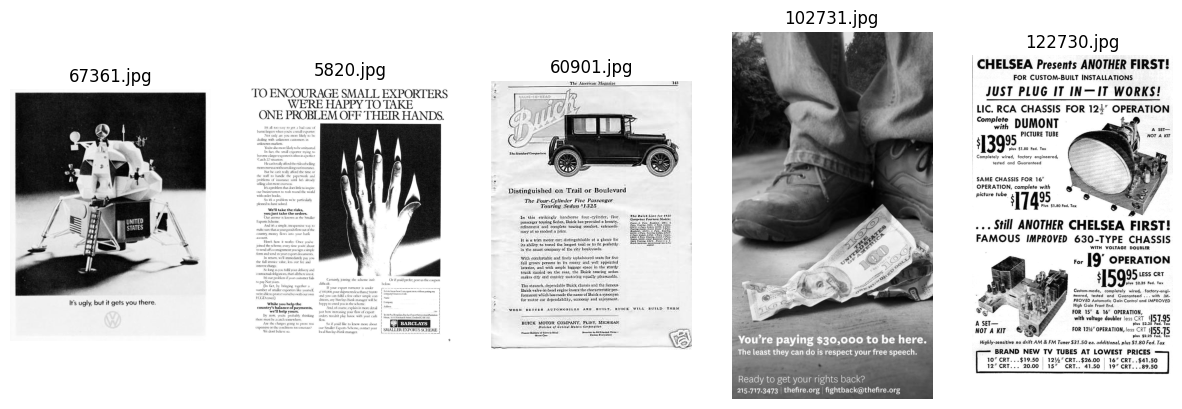

In [311]:
# Sample grayscale images 

gray_images = [image_df['File_Name'][i] for i in range(len(image_df)) if image_df['Mode'][i]=='L']

num_images_to_display = NUM_IMAGES
if len(gray_images) < num_images_to_display:    
    num_images_to_display = len(gray_images)

plot_random_images(gray_images,num_images_to_display)

In [312]:
# Blur Images
# using blurry in the context of low_res or fuzzy, non-sharp images

def detect_blur(image_path, threshold=20):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    is_blurry = variance < threshold
    return variance, is_blurry

blur_list=[]
laplacian_variance = []
for file in image_df['File_Name']:
    img_path= os.path.join(DATASET_PATH, file)
    variance, is_blurry = detect_blur(img_path)
    laplacian_variance.append(variance)
    if is_blurry:
        blur_list.append('Yes')
    else:
        blur_list.append('No')
       

Blur
No     11091
Yes       15
Name: count, dtype: int64


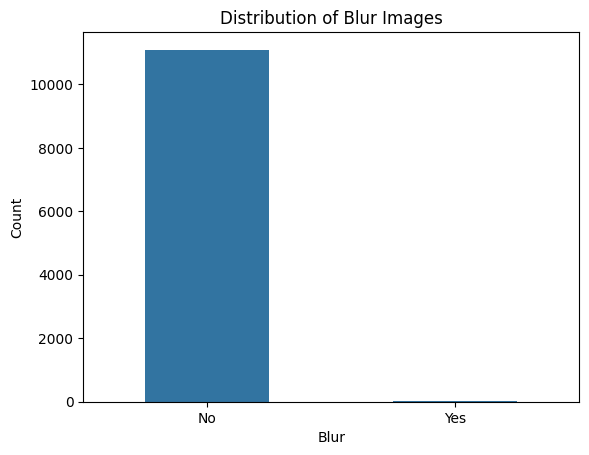

In [313]:
image_df['Blur']= blur_list
blur_counts = image_df['Blur'].value_counts()
sns.barplot(x=blur_counts.index, y=blur_counts.values,width=0.5)
plt.title('Distribution of Blur Images')
plt.xlabel('Blur')
plt.ylabel('Count')
print(blur_counts)

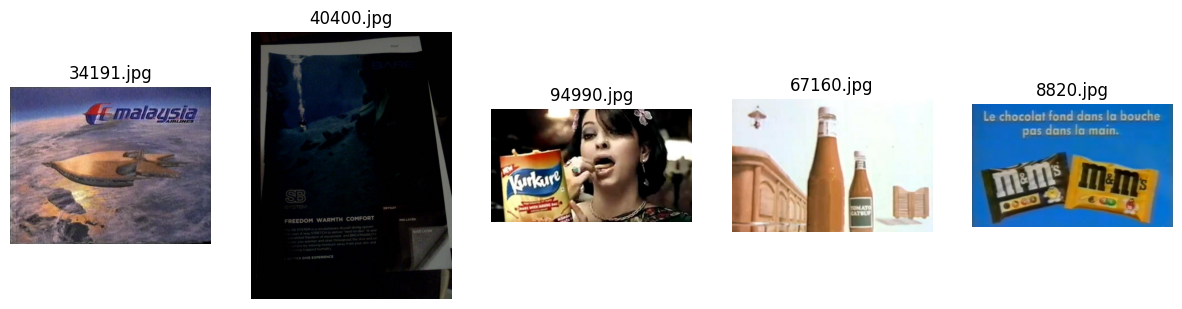

In [318]:
# Sample blur images
blur_images = [image_df['File_Name'][i] for i in range(len(image_df)) if image_df['Blur'][i]=='Yes']

num_images_to_display = NUM_IMAGES
if len(blur_images) < num_images_to_display:    
    num_images_to_display = len(blur_images)

plot_random_images(blur_images,num_images_to_display)